#### Upload dataset from google drive

In [106]:
!pip install gdown
!pip install tensorflow

In [107]:
import os
import gdown
import zipfile
import pydot
from pathlib import Path

from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [108]:
# Downloading Dataset and extracting data points
file_id = "1unDpBmcZidHfTgKyqaMnh6EMcdVeBvzw"
output = "dataset.zip"

data_dir = Path("data")
if data_dir.exists() and any(data_dir.iterdir()):
    print("data directory already exists and contains files — skipping download/extract.")
else:
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("data")

    os.remove(output)

data directory already exists and contains files — skipping download/extract.


#### Load dataset from folders into numpy arrays

In [109]:
def load_dataset(data_dir, image_size=(128, 128)):
    data_dir = Path(data_dir)
    images = []
    labels = []

    classes = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    for label_index, class_name in enumerate(classes):
        class_dir = data_dir / class_name
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in [".jpg", ".png", ".jpeg"]:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                images.append(np.array(img) / 255.0)  # normalize to [0,1]
                labels.append(label_index)

    return np.array(images), np.array(labels), classes

# Training/Test Split
X_train, y_train, classes = load_dataset("data/training/training")
X_test, y_test, _ = load_dataset("data/validation/validation")

print("Training images:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test images:", X_test.shape)
print("Test labels:", y_test.shape)

Training images: (1097, 128, 128, 3)
Training labels: (1097,)
Test images: (272, 128, 128, 3)
Test labels: (272,)


#### Convert numpy arrays into _TensorSliceDataset, make the test dataset from the validation set

In [110]:
training_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# make test dataset from validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 218
Number of test batches: 54


#### Plot some training data points

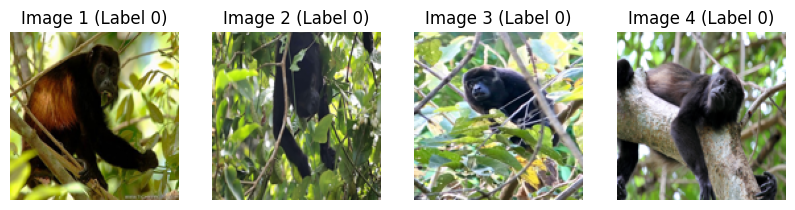

In [111]:
plt.figure(figsize=(10, 5))

for i, (image, label) in enumerate(training_dataset.take(4)):  
    image_numpy = image.numpy()  # convert image tensor → numpy

    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image_numpy)
    plt.title(f"Image {i+1} (Label {label.numpy()})")
    plt.axis("off")

plt.show()

#### Configure datasets (shuffle, batch, prefetch)

In [112]:
training_dataset = training_dataset.shuffle(buffer_size=len(X_train))
training_dataset = training_dataset.batch(batch_size=32)

validation_dataset = validation_dataset.shuffle(buffer_size=len(X_train))
validation_dataset = validation_dataset.batch(batch_size=32)

training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#### Data Augmentation

In [113]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
])

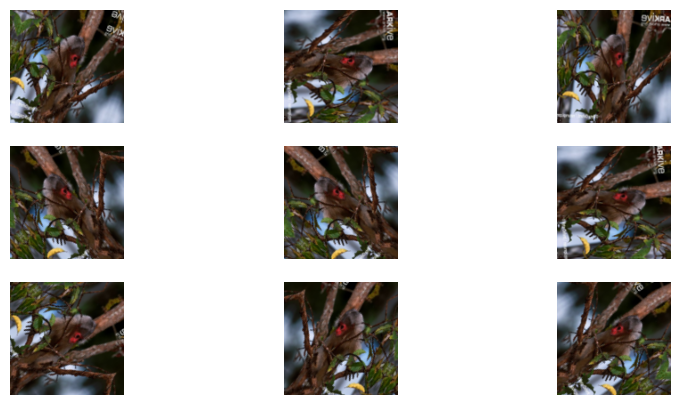

In [114]:
plt.figure(figsize=(10, 5))

for images, labels in training_dataset.take(1):  
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

plt.show()

#### Rescale pixel values to fit MobileNetV2

In [115]:
# The following code is brought over from rescaling the input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

#### Create base model MobileNet V2 (before hyperparameter tuning)

In [116]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), # Represents dataset image dimensions of 128x128 pixels and with 3 color channels
                                               alpha=1.0,
                                               include_top=False,
                                               weights='imagenet')

In [117]:
image_batch, label_batch = next(iter(training_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freezing
base_model.trainable = False

(32, 4, 4, 1280)


In [118]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_56      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_56[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [119]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [120]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [121]:
inputs = tf.keras.Input(shape=(128, 128, 3))

x = rescale(inputs)

x = data_augmentation(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_57 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_24 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_29     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Above, our model is equipped with 12,810 trainable parameters. This is due to the fact our dataset has 10 classifications, and subsequently about 10 times the trainable params as are found in the CNN discussed in class.

In [122]:
len(model.trainable_variables)

2

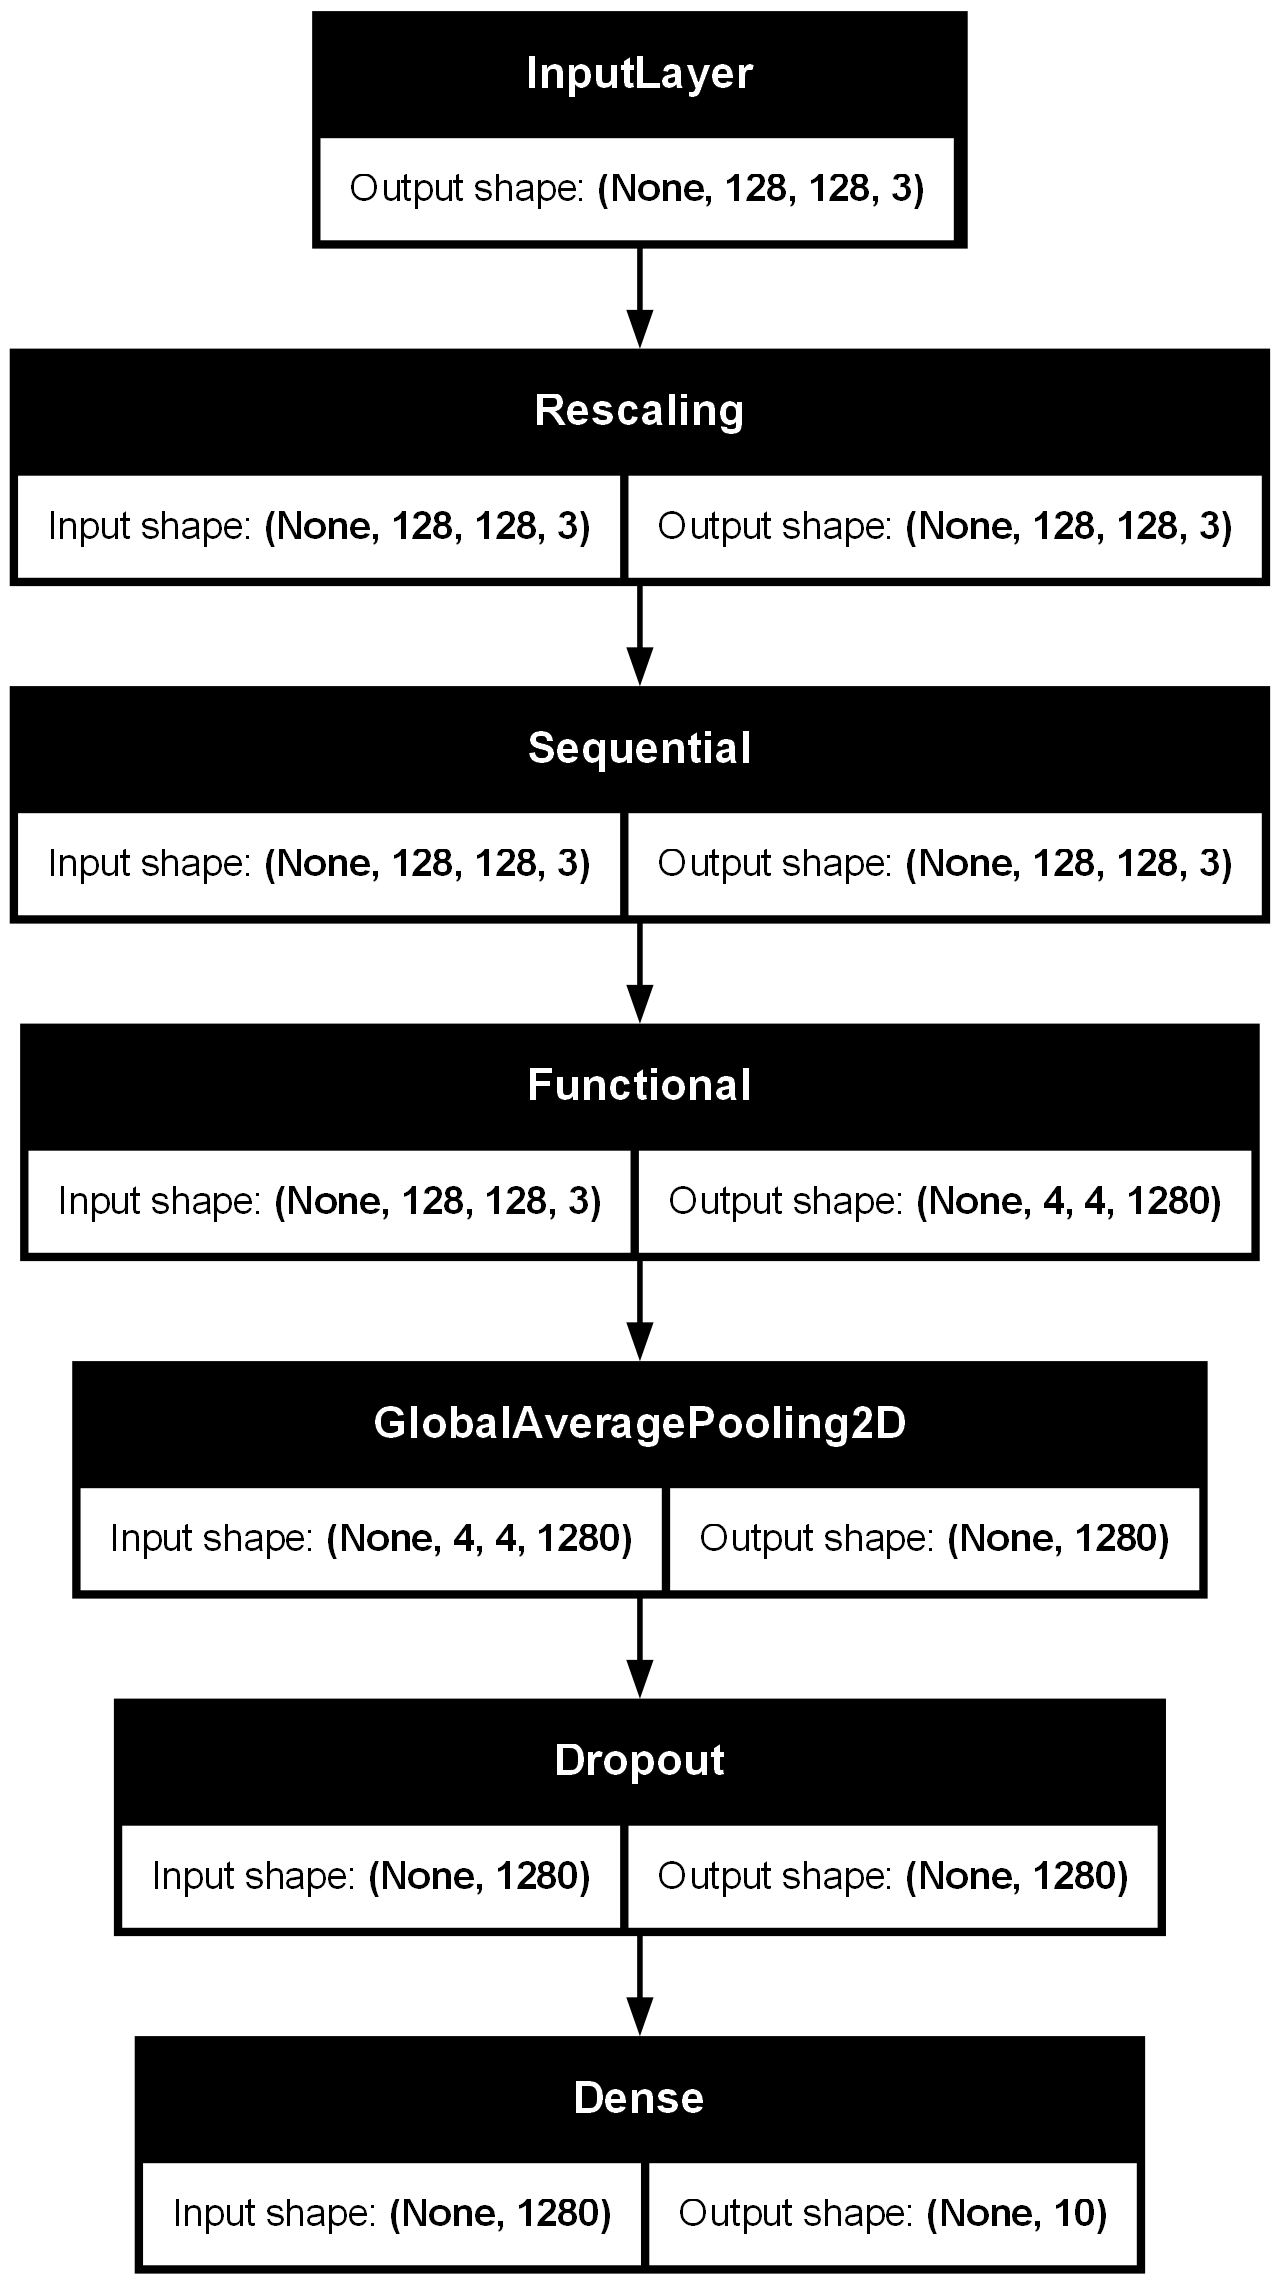

In [123]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Model Compilation

In [124]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            #   loss=tf.keras.losses.BinaryCrossentropy(),
            #   metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [125]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.0000e+00 - loss: 3.2873


In [126]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.29
initial accuracy: 0.00


In [127]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.0930 - loss: 2.7302 - val_accuracy: 0.0000e+00 - val_loss: 2.5387
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.0884 - loss: 2.4787 - val_accuracy: 0.0000e+00 - val_loss: 2.3436
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.1112 - loss: 2.4249 - val_accuracy: 0.0917 - val_loss: 2.3167
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.0766 - loss: 2.4727 - val_accuracy: 0.1468 - val_loss: 2.2978
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.0957 - loss: 2.4101 - val_accuracy: 0.1330 - val_loss: 2.3024
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.1021 - loss: 2.4343 - val_accuracy: 0.1284 - val_loss: 2.2892
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.1076 - loss: 2.4260 - val_accuracy: 0.1651 - val_loss: 2.2856
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.0957 - loss: 2.4331 - val_accur

## Model Analysis: Learning Curve

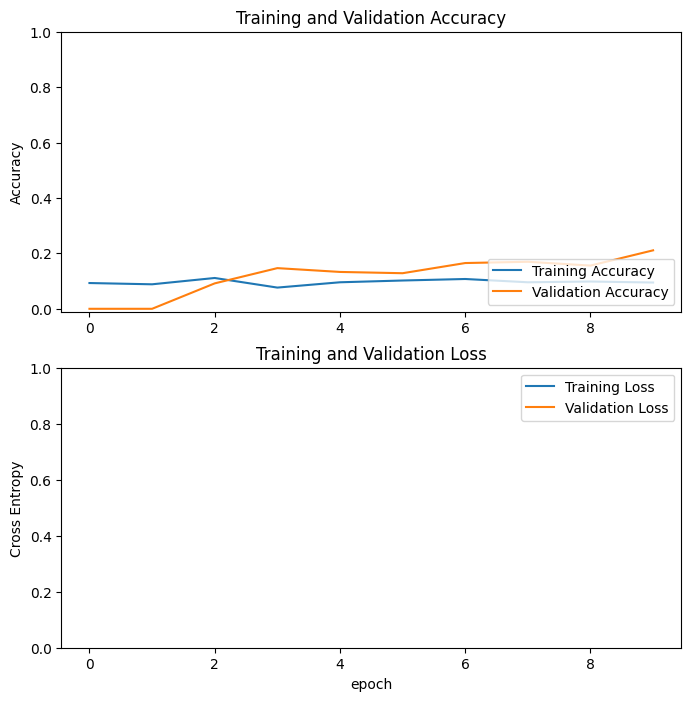

In [128]:
def make_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

make_learning_curves(history)

#### Start tuning hyperparameters

In [129]:
param_grid = {
    "learning_rate": [1e-4, 1e-3],
    "optimizer": ["adam", "sgd"],
    "dropout_rate": [0.2, 0.3],
    "dense_units": [128, 256],
    "batch_size": [16, 32],
    "fine_tune_layers": [20, 30]
}

def build_model(params):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               alpha=1.0,
                                               include_top=False,
                                               weights='imagenet')
    
    # freeze all layers except the last
    for layer in base_model.layers[:-params["fine_tune_layers"]]:
        layer.trainable = False
    for layer in base_model.layers[-params["fine_tune_layers"]:]:
        layer.trainable = True

    # Model head
    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(params["dropout_rate"]),
        tf.keras.layers.Dense(params["dense_units"], activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust number of classes if needed
    ])

    # Choose optimizer
    if params["optimizer"] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])
    elif params["optimizer"] == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=params["learning_rate"], momentum=0.9)




    # Compile model
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

#### Run different combinations of the hyperparameters + outputting history plots


 Iteration 1: {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 20}


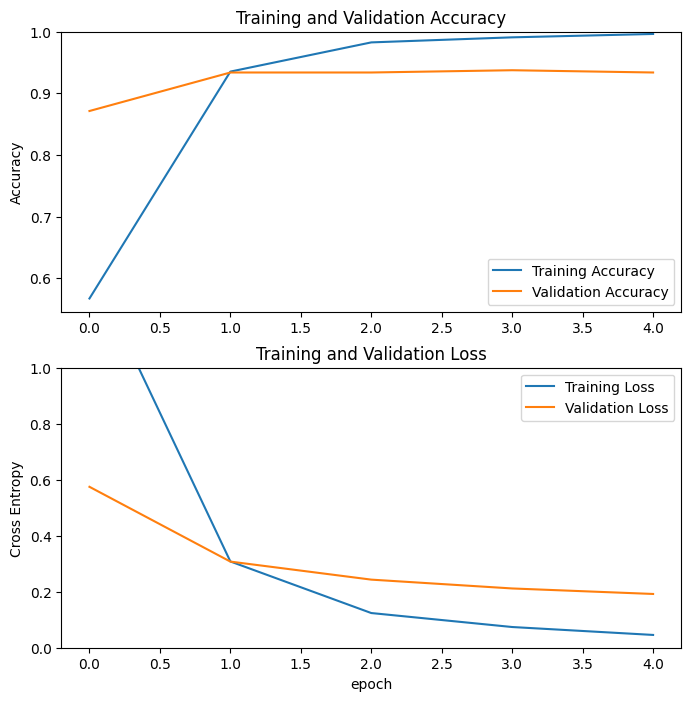


 Iteration 2: {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 30}


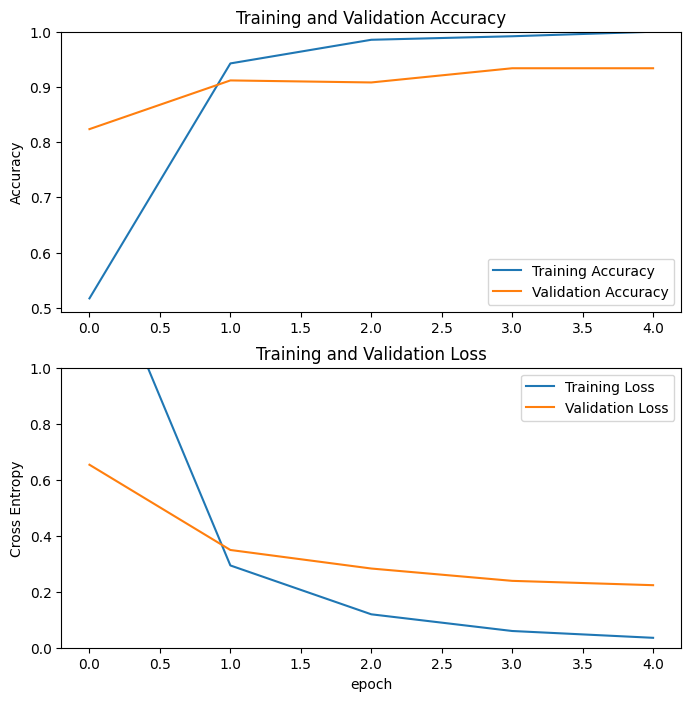


 Iteration 3: {'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 16, 'fine_tune_layers': 20}


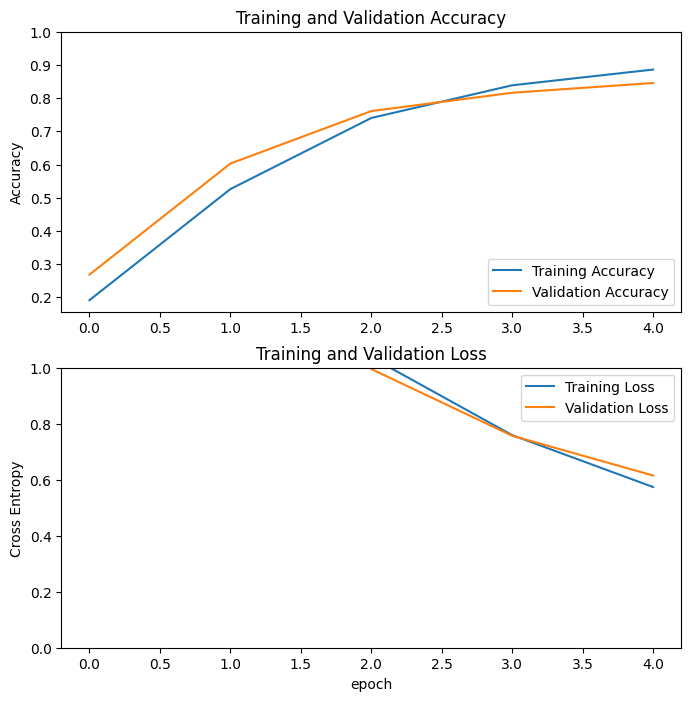


 Iteration 4: {'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}


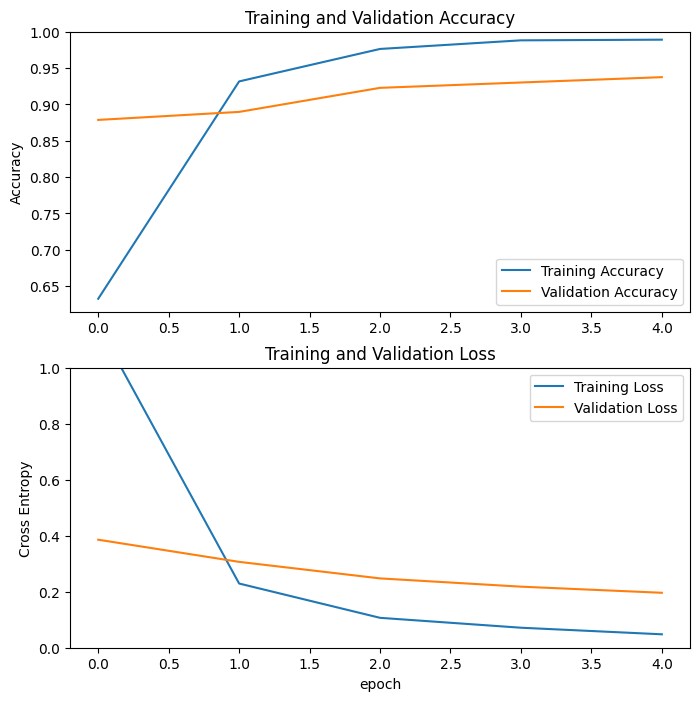


 Iteration 5: {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 30}


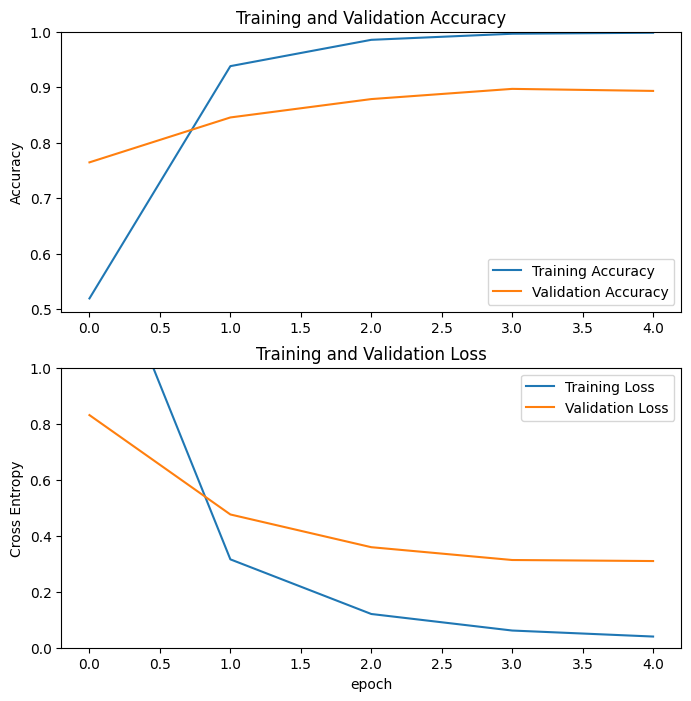


 Iteration 6: {'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 20}


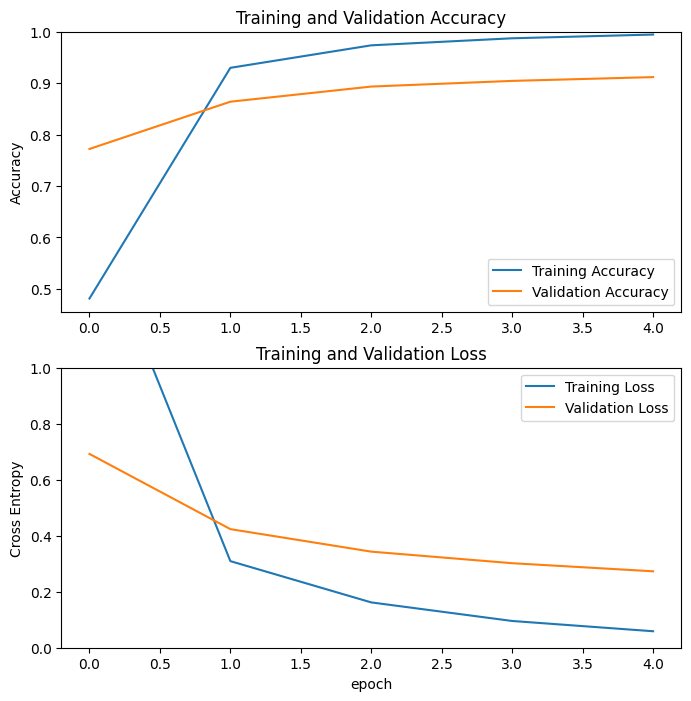


 Iteration 7: {'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 20}


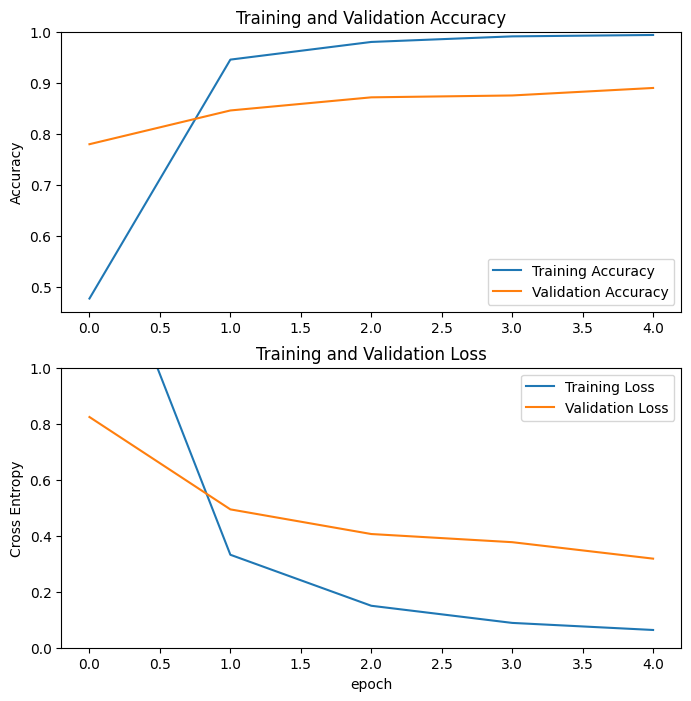


 Iteration 8: {'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}


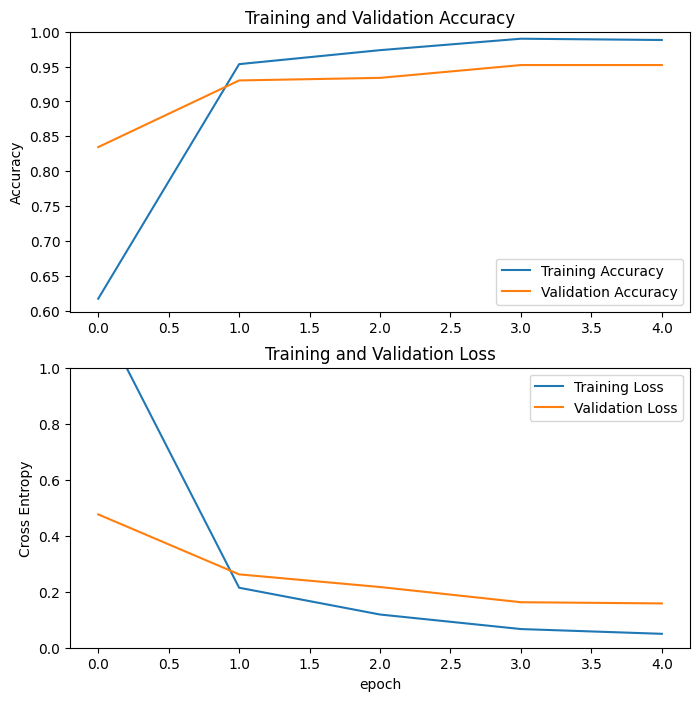


 Iteration 9: {'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 20}


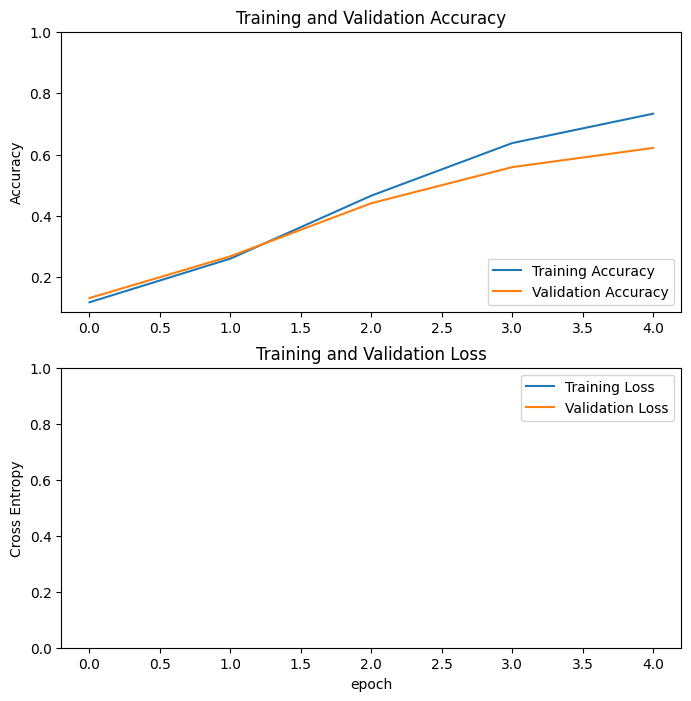


 Iteration 10: {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}


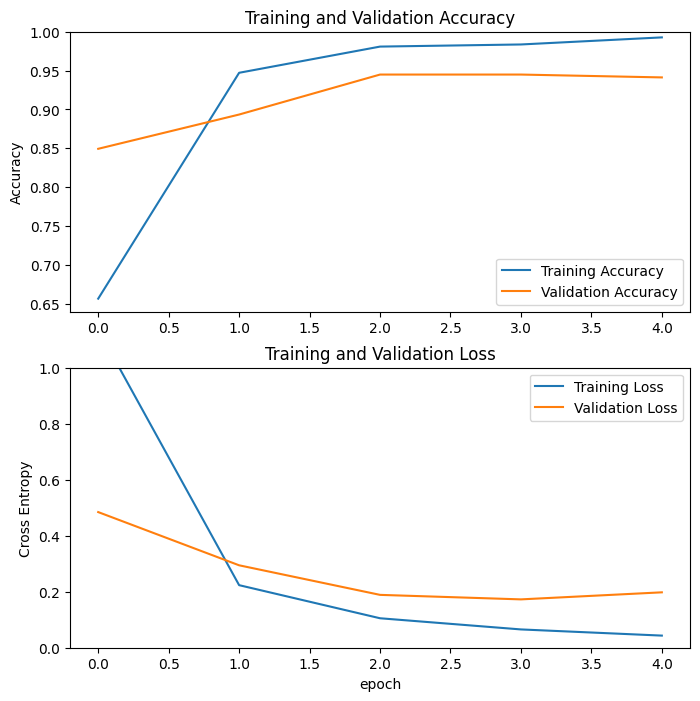


 Iteration 11: {'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 30}


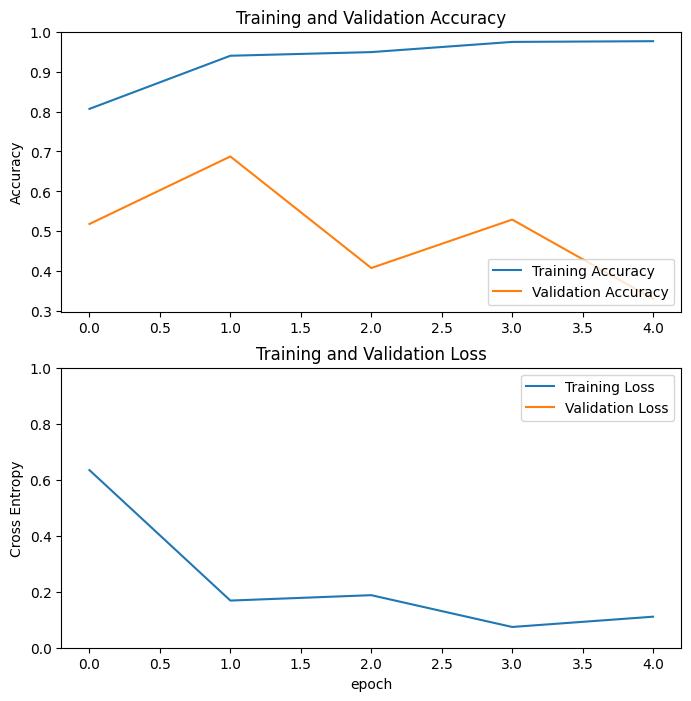


 Iteration 12: {'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 20}


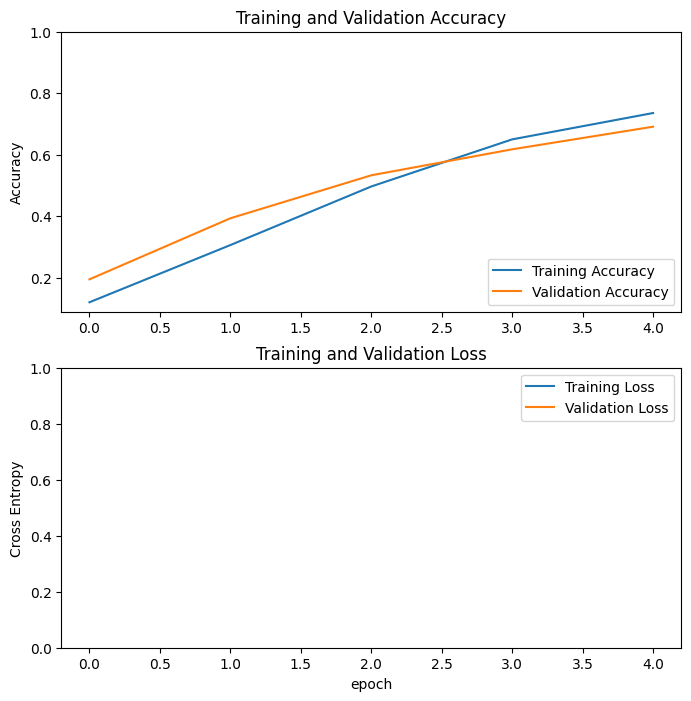


 Iteration 13: {'learning_rate': 0.001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 20}


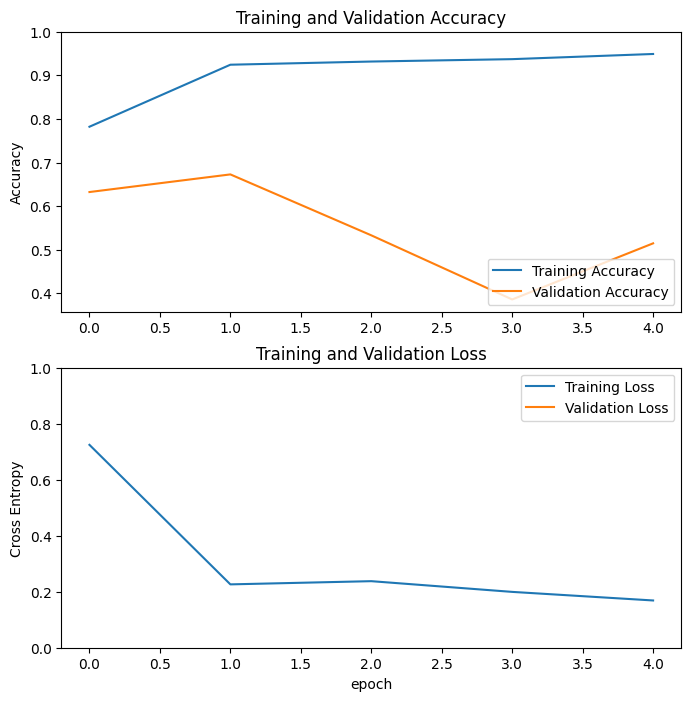


 Iteration 14: {'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 30}


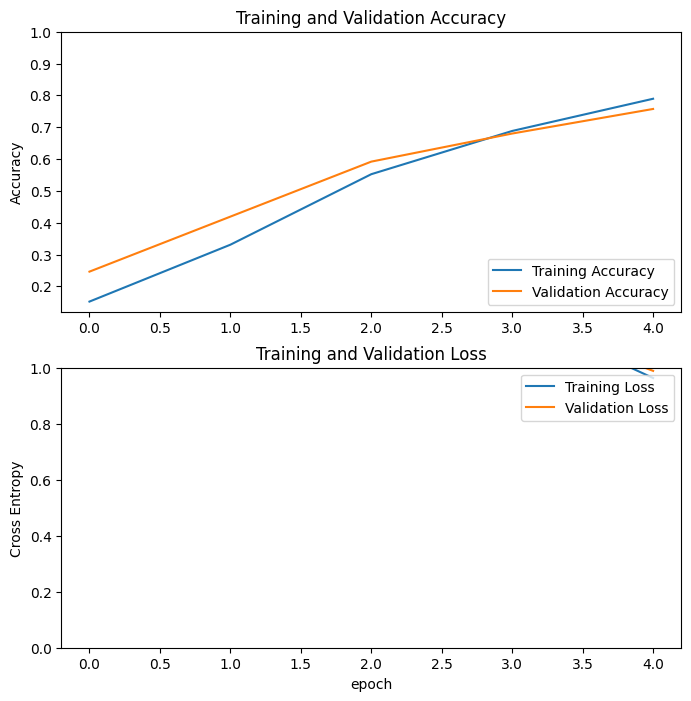


 Iteration 15: {'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 20}


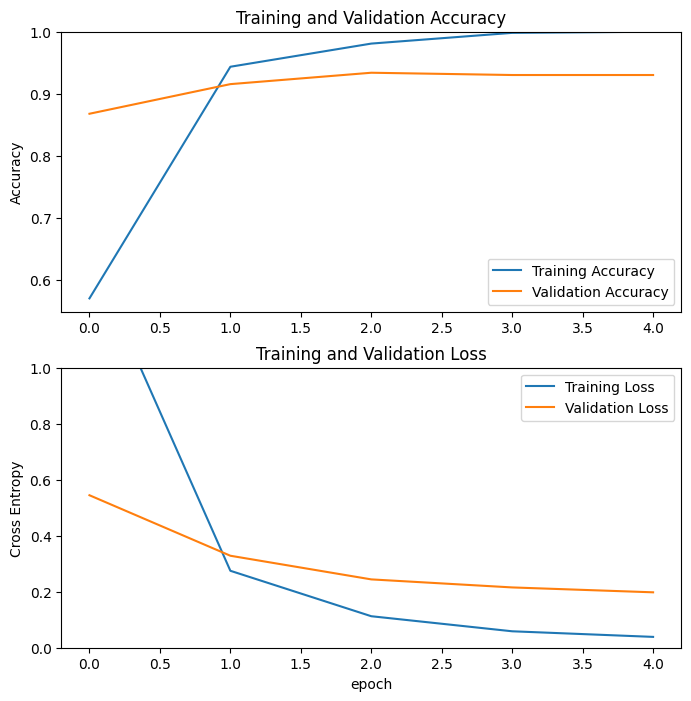

In [130]:
results = []

# Run 20 random configurations from params_grid to find which has the best test_val without overfitting
for i in range(1, 16):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"\n Iteration {i}: {params}")

    model = build_model(params)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=5,  # adjust as needed
        batch_size=params["batch_size"],
        verbose=0
    )
    make_learning_curves(history)

    train_acc = history.history['accuracy'][-1]
    test_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    test_loss = history.history['val_loss'][-1]

    results.append({
        "Iteration": i,
        "Hyperparameters": params,
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4),
        "Train Loss": round(train_loss, 4),
        "Test Loss": round(test_loss, 4),
    })


#### Outputting the Hyperparamter tuning and results table

In [ ]:
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(results)
print("\nTuning Summary Table:\n")
display(results_df)


Tuning Summary Table:



,Iteration,Hyperparameters,Train Accuracy,Test Accuracy,Train Loss,Test Loss
0,1,"{'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 20}",0.9964,0.9338,0.0457,0.1920
1,2,"{'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 30}",1.0000,0.9338,0.0354,0.2233
2,3,"{'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 16, 'fine_tune_layers': 20}",0.8861,0.8456,0.5739,0.6151
3,4,"{'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}",0.9891,0.9375,0.0479,0.1962
4,5,"{'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 30}",0.9982,0.8934,0.0399,0.3096
5,6,"{'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32, 'fine_tune_layers': 20}",0.9945,0.9118,0.0588,0.2729
6,7,"{'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 20}",0.9936,0.8897,0.0634,0.3181
7,8,"{'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}",0.9881,0.9522,0.0496,0.1582
8,9,"{'learning_rate': 0.0001, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 32, 'fine_tune_layers': 20}",0.7329,0.6213,1.0960,1.1723
9,10,"{'learning_rate': 0.0001, 'optimizer': 'adam', 'dropout_rate': 0.2, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}",0.9927,0.9412,0.0433,0.1978


#### Example test data based on best params

In [132]:
best_row = results_df.loc[results_df["Test Accuracy"].idxmax()]

print("Best Hyperparameter Combination Found:")
print(best_row["Hyperparameters"])
print(f"\nTrain Accuracy: {best_row['Train Accuracy']:.4f}")
print(f"Test Accuracy: {best_row['Test Accuracy']:.4f}")

model = build_model(best_row["Hyperparameters"])

Best Hyperparameter Combination Found:
{'learning_rate': 0.001, 'optimizer': 'sgd', 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 16, 'fine_tune_layers': 30}

Train Accuracy: 0.9881
Test Accuracy: 0.9522


In [133]:
# The following parameters are derived from the hyperparameters of iteration 6 (index: 5)
best_params = {
    "learning_rate": 0.0001,
    "optimizer": "sgd",
    "dropout_rate": 0.2,
    "dense_units": 256,
    "batch_size": 16,
    "fine_tune_layers": 20
}

model2 = build_model(best_params)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step

Top 25 Predictions Summary:



,Index,True Label,Predicted Label
0,177,6,5
1,101,3,8
2,229,8,8
3,108,3,1
4,11,0,5
5,187,6,8
6,22,0,5
7,74,2,7
8,193,7,6
9,225,8,8


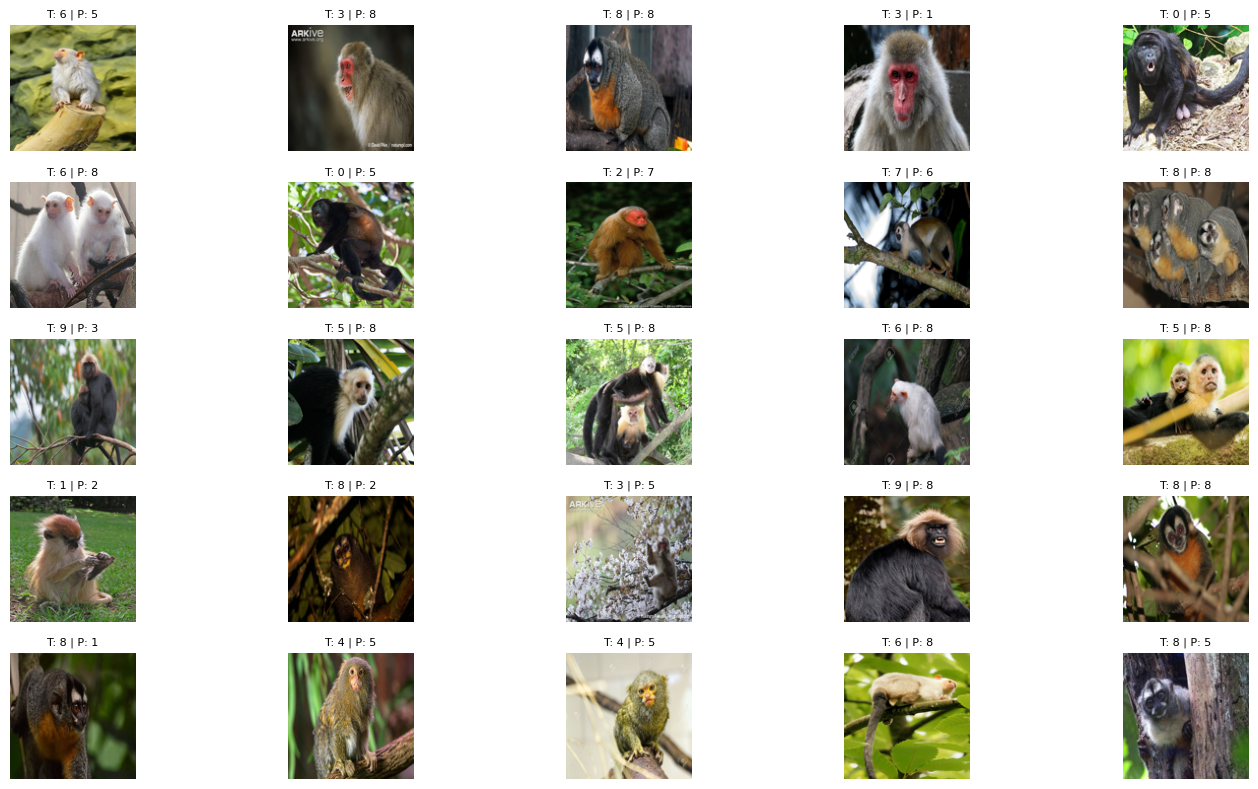

In [134]:
# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 25 random samples (first 25 for reproducibility)
num_samples = min(25, len(X_test))
indices = np.random.choice(len(X_test), size=num_samples, replace=False)

sample_data = X_test[indices]
true_labels = y_test[indices]
pred_labels = y_pred[indices]

# Create a DataFrame summary

results_df = pd.DataFrame({
    "Index": indices,
    "True Label": true_labels,
    "Predicted Label": pred_labels
})

print("\nTop 25 Predictions Summary:\n")
display(results_df)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"T: {y_test[idx]} | P: {y_pred[idx]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()